![](https://images.pexels.com/photos/3967818/pexels-photo-3967818.jpeg?auto=compress&cs=tinysrgb&h=750&w=1260)

# CNN with Keras and Tensorflow Backend

Kevin Walchko

10 Aug 2019

---

Cat detector, trained using the tiny imagenet dataset. The images from n02120xx - n02129xx are all some kind of cat.

### References

- [ResNet with Tensorflow](https://github.com/taki0112/ResNet-Tensorflow)
- [c231 Image Data: tiny-imagenet](https://tiny-imagenet.herokuapp.com/)
- [dogs vs cats](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-to-classify-photos-of-dogs-and-cats/)
---

In [1]:
%matplotlib inline

In [2]:
# math and plotting things loaded
import matplotlib.pyplot as plt
import numpy as np

In [3]:
import simplejson as json

In [4]:
# get some file/directory stuff setup
import os
from os import listdir as ls
def mkdir(path):
    try:
        os.mkdir(path)
    except FileExistsError:
        # folder was already created ... it's ok
        pass

In [5]:
# import cv2
from PIL import Image
from glob import glob

In [38]:
def show(path):
    img = Image.open(path)
    plt.imshow(img)
    plt.title(path);

In [7]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50
from keras.applications.resnet50 import preprocess_input
from keras import Model, layers
from keras.models import load_model, model_from_json
from keras.utils import plot_model

# convert the PIL image to a numpy array
# IN PIL - image is in (width, height, channel)
# In Numpy - image is in (height, width, channel)
from keras.preprocessing.image import img_to_array

In [8]:
# keep track of the version of software we are useing
print("Keras: {}".format(keras.__version__))
print("Python {}".format((os.sys.version_info[:3])))
print("Tensorflow: {}".format(keras.backend.tf.__version__))
# print(tf.keras.__version__)

Keras: 2.2.4
Python (3, 7, 4)
Tensorflow: 1.14.0


## Cat Detector

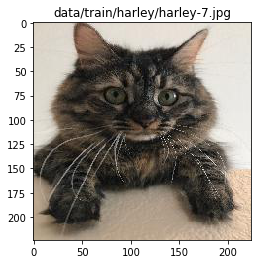

In [84]:
# long hair maincoon 
show("data/train/harley/harley-7.jpg")

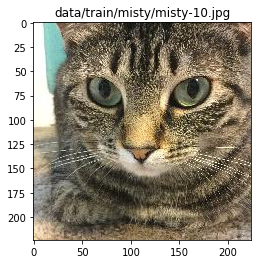

In [89]:
# short hair grey tiger
show("data/train/misty/misty-10.jpg")

## Setup Data

In [49]:
def prep_data(cat, folder):
    mkdir("data")
    mkdir("data/" + folder)
    dest = "data/" + folder + "/" + cat
    mkdir(dest)
    
    for i, fname in enumerate(glob("cats/" + cat + "/" + folder + "/*.jpg")):
        im = Image.open(fname)
        im = im.resize((224, 224))
#         print(fname)
#         print("{}/{}-{}.jpg".format(dest,cat,i))
        im.save("{}/{}-{}.jpg".format(dest,cat,i))

In [74]:
prep_data("harley", "train")
prep_data("harley", "validate")
prep_data("harley", "test")

prep_data("misty", "train")
prep_data("misty", "validate")
prep_data("misty", "test")

## Create Model

In [51]:
conv_base = ResNet50(
    include_top=False,
    weights='imagenet')

for layer in conv_base.layers:
    layer.trainable = False

/Users/kevin/pyvenv/cv/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [52]:
CLASSES = 2
x = conv_base.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x) 
predictions = layers.Dense(CLASSES, activation='softmax')(x)
model = Model(conv_base.input, predictions)

In [53]:
optimizer = keras.optimizers.Adam()
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

## Training the Model

In [78]:
EPOCHS = 5
BS = 32

In [79]:
print("Model set to learn {} classes of objects".format(CLASSES))

# data_path = 'large_dataset/tiny-imagenet-200/'
data_path = "data/"

train_datagen = ImageDataGenerator(
    shear_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    data_path + 'train',
    batch_size=BS,
    class_mode='binary',
    target_size=(224,224))  # wants 224x224

validation_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    data_path + 'validate',
    shuffle=False,
    class_mode='binary',
    target_size=(224,224))

Model set to learn 2 classes of objects
Found 115 images belonging to 2 classes.
Found 27 images belonging to 2 classes.


In [80]:
history = model.fit_generator(generator=train_generator,
                              epochs=EPOCHS,
                              steps_per_epoch=train_generator.samples/BS,
                              validation_steps=validation_generator.samples/BS,
                              validation_data=validation_generator)

Epoch 1/5
4/3 [=================================] - 19s 5s/step - loss: 0.0067 - acc: 1.0000 - val_loss: 0.3051 - val_acc: 0.9259
Epoch 2/5
4/3 [=================================] - 18s 5s/step - loss: 0.0063 - acc: 1.0000 - val_loss: 0.2857 - val_acc: 0.9259
Epoch 3/5
4/3 [=================================] - 18s 4s/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.2762 - val_acc: 0.9259
Epoch 4/5
4/3 [=================================] - 18s 4s/step - loss: 0.0184 - acc: 1.0000 - val_loss: 0.3308 - val_acc: 0.9259
Epoch 5/5
4/3 [=================================] - 17s 4s/step - loss: 0.0186 - acc: 1.0000 - val_loss: 0.3013 - val_acc: 0.9259


## Save the Model

In [63]:
mkdir("models")

if 0:
    model.save('models/model.h5')
    model.save_weights('models/weights.h5')
    with open('models/architecture.json', 'w') as f:
            f.write(model.to_json())

print(ls("models"))

['architecture.json', 'model.h5', 'weights.h5']


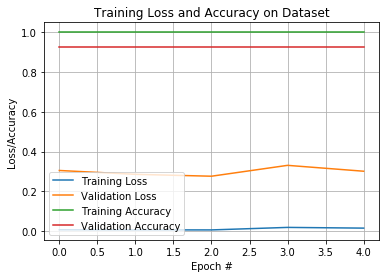

In [81]:
H = history
plt.plot(np.arange(0, EPOCHS), H.history["loss"], label="Training Loss")
plt.plot(np.arange(0, EPOCHS), H.history["val_loss"], label="Validation Loss")
plt.plot(np.arange(0, EPOCHS), H.history["acc"], label="Training Accuracy")
plt.plot(np.arange(0, EPOCHS), H.history["val_acc"], label="Validation Accuracy")
plt.title("Training Loss and Accuracy on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.grid(True);
# plt.savefig("plot.png")

# Predict

In [65]:
# def imshow(f, prob, sz=300):
#     """
#     Given a filename, display it and print the probability value on it
#     """
#     img = Image.open(f)
#     img = img.resize((sz,sz),Image.ANTIALIAS)
# #     cv2.putText(img,prob,(10,sz), cv2.FONT_HERSHEY_SIMPLEX, 4,(0,255,0),8,cv2.LINE_AA)
#     plt.imshow(img)
#     plt.axis('off')

In [72]:
def run(validation_img_paths, threshold=.8):
    """
    threshold: prediction probability an image belongs to a label
    0 - alien
    1 - predator
    """
    img_list = [img_to_array(Image.open(img_path)) for img_path in validation_img_paths]
    validation_batch = np.stack(
        [preprocess_input(img) for img in img_list]
    )
    pred_probs = model.predict(validation_batch)
    
    for file, im_prob in zip(validation_img_paths, pred_probs):
        f = file.split('/')[3]
        f = f.replace(".jpg", "")
        print(">> {:9}: {:4.0f} {:4.0f}".format(f, *(im_prob*100)))

In [82]:
data = []
for cat in ["harley", "misty"]:
    data += glob("data/test/{}/*.jpg".format(cat))
data.sort()
run(data)

>> harley-0 :   27   73
>> harley-1 :  100    0
>> harley-2 :   84   16
>> harley-3 :   93    7
>> misty-0  :   11   89
>> misty-1  :   85   15
>> misty-2  :   37   63
>> misty-3  :    0  100
